In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.SimultaneousQuantileRegressor import SimultaneousQuantileRegressor, SimultaneousQuantileMixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = SimultaneousQuantileRegressor(SimultaneousQuantileMixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        2.6638        1.1382  8.6382
      2        0.5711        0.2700  8.3976
      3        0.2260        0.2020  8.5493
      4        0.2033        0.2043  8.2725
      5        0.1926        0.1789  8.2337
      6        0.1917        0.1862  8.5534
      7        0.1952        0.2007  8.4257
      8        0.1859        0.1741  8.7290
      9        0.1773        0.1778  8.6531
     10        0.1770        0.1762  8.4736
     11        0.1704        0.1645  8.6697
     12        0.1613        0.1380  8.6671
     13        0.1558        0.1692  8.4971
     14        0.1499        0.1526  8.4215
     15        0.1465        0.1405  8.4711
     16        0.1479        0.1415  8.6909
     17        0.1474        0.1424  8.4063
     18        0.1461        0.1483  8.3869
     19        0.1447        0.1364  8.3034
     20        0.1416        0.1432  8.4901
     21        0.1415        0.1

<class 'tabularasa.SimultaneousQuantileRegressor.SimultaneousQuantileRegressor'>[initialized](
  module_=SimultaneousQuantileMixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=18, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=18, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
       

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

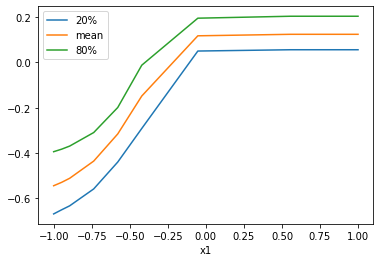

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

In [9]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values})

array([[-0.38118905],
       [-0.31961358],
       [-0.27545747],
       ...,
       [ 0.18136154],
       [ 0.2036933 ],
       [ 0.17625192]], dtype=float32)

In [10]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.5)

array([[-0.38118905],
       [-0.31961358],
       [-0.27545747],
       ...,
       [ 0.18136154],
       [ 0.2036933 ],
       [ 0.17625192]], dtype=float32)

In [11]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.9)

array([[0.2745663 ],
       [0.3129935 ],
       [0.34946668],
       ...,
       [0.57527286],
       [0.5813318 ],
       [0.5706511 ]], dtype=float32)

In [12]:
model.predict({'X_monotonic': df[['x1', 'x2']].values,
               'X_non_monotonic': df[['x3', 'x4']].values}, q=0.1)

array([[-1.1761633 ],
       [-1.0345591 ],
       [-1.0266426 ],
       ...,
       [-0.26164448],
       [-0.24790198],
       [-0.26133406]], dtype=float32)

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [21]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

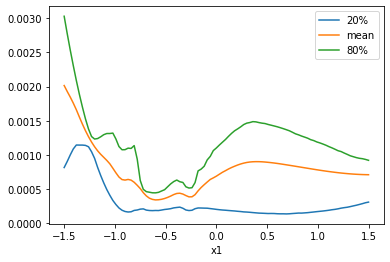

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.